In [1]:
import scanpy as sc
import anndata
import MultiMAP

sc.settings.set_figure_params(dpi=80)

This notebook covers the use of MultiMAP for multi-omic integration and batch correction of single cell data.

To start, we'll apply MultiMAP to a pair of datasets, one of them scRNA-seq, the other scATAC-seq. The ATAC data was generated and annotated in [Chen et al., 2018](https://www.nature.com/articles/s41467-018-07771-0), while the RNA data was generated as part of the MultiMAP manuscript and annotated to match. This is the more complex case, as the ATAC data will be processed with LSI prior to the integration.

The AnnData objects are hosted on ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP (appropriate locations provided to `backup_url`)

In [2]:
rna = sc.read('rna.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/rna.h5ad')
atac_peaks = sc.read('atac-peaks.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/atac-peaks.h5ad')
atac_genes = sc.read('atac-genes.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/atac-genes.h5ad')

As part of its operation, MultiMAP will compute PCA reductions of combinations of the input data. In contrast to standard operating procedures for RNA analysis, it is recommended to avoid highly variable gene filtering, only removing unexpressed/scarcely present genes. This grants the method as much overlapping information as possible between the datasets to try to find commonalities.

There are two forms of ATAC data imported - a peak matrix, and a gene space. It is important to have a shared gene space between the processed datasets to enable shared PCA computation. In the case of ATAC data, converting peaks to genes can be performed with tools such as [SnapATAC](https://github.com/r3fang/SnapATAC) or [Signac](https://satijalab.org/signac/).

In [3]:
[rna.shape, atac_peaks.shape, atac_genes.shape]

[(4382, 13575), (3166, 126590), (3166, 19410)]

The input to MultiMAP is an AnnData object per dataset to integrate, with a log-normalised gene space in `.X` and a primary dimensionality reduction somewhere in `.obsm`. Once again, using a large gene space is encouraged to capture as much information about the dataset as possible. The data in `.X` should not be scaled, as the output object will be created by concatenating the individual inputs. As such, this will make the result better for downstream analysis - scaled expression data is less informative.

We're going to compute a standard PCA for the RNA data, and represent the ATAC peak space as LSI coordinates after a TF-IDF transformation. A helper function to perform this is included as `Multimap.TFIDF_LSI()`. Once we compute this dimensionality reduction, we'll copy it over to the gene space representation of the ATAC data. We'll also briefly use a helper object to compute a PCA for the RNA data, as PCA computation requires the data to be scaled, and copy the resulting coordinates to the object with un-scaled data.

In [4]:
MultiMAP.TFIDF_LSI(atac_peaks)
atac_genes.obsm['X_lsi'] = atac_peaks.obsm['X_lsi'].copy()

rna_pca = rna.copy()
sc.pp.scale(rna_pca)
sc.pp.pca(rna_pca)
rna.obsm['X_pca'] = rna_pca.obsm['X_pca'].copy()

Now that we have all our datasets present with a log-normalised gene space in `.X` and a primary dimensionality reduction in `.obsm`, we can run `MultiMAP.Integration()`. The function accepts a list of the AnnData objects on input, along with a second list with the names of the primary dimensionality reductions to use (as we're using `X_pca` for our RNA and `X_lsi` for our ATAC).

In [5]:
adata = MultiMAP.Integration([rna, atac_genes], ['X_pca', 'X_lsi'])

The output is an AnnData object with the MultiMAP embedding stored in `.obsm['X_multimap']`, plus corresponding neighbourhood graphs in `.obsp`.

... storing 'cell_type' as categorical
... storing 'source' as categorical


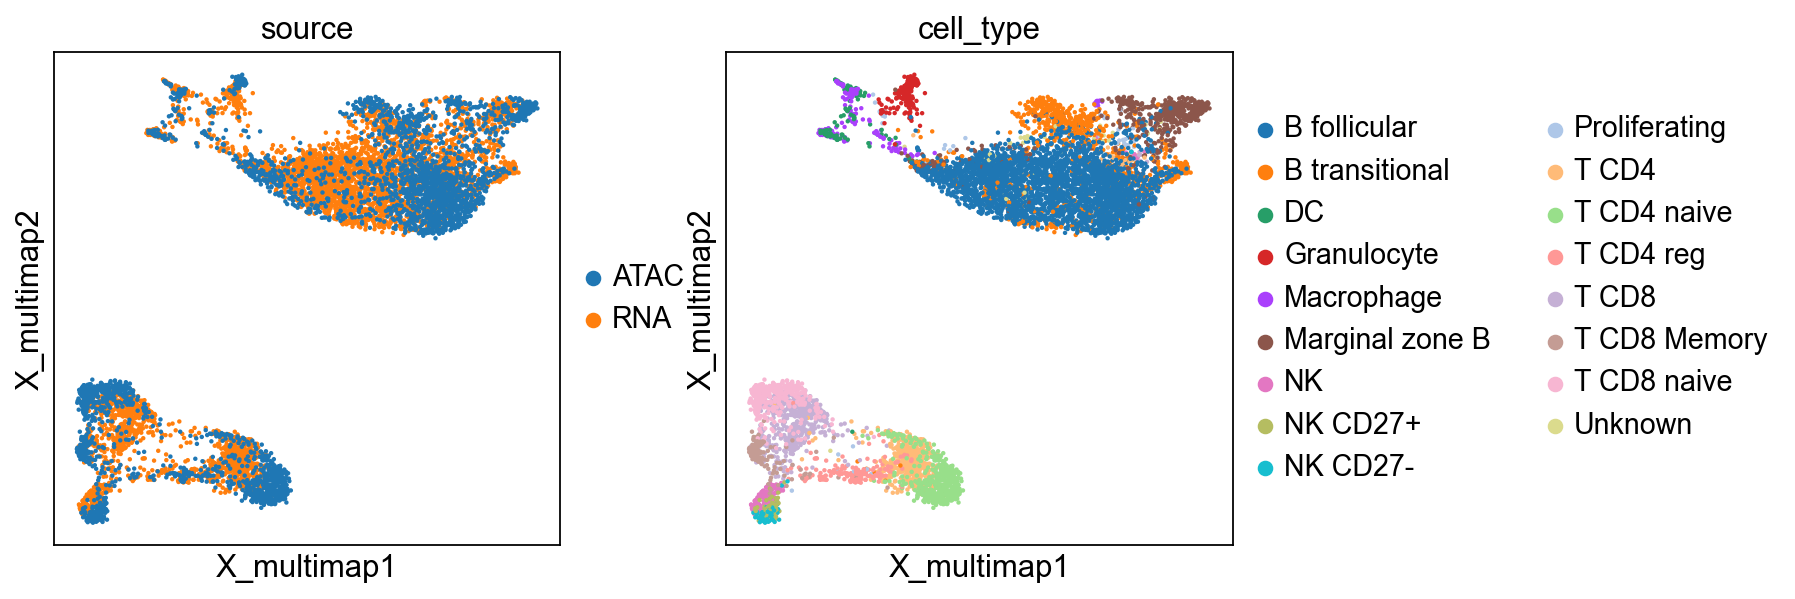

In [6]:
sc.pl.embedding(adata, 'X_multimap', color=['source','cell_type'])

The graph can be used for downstream Scanpy analysis, such as clustering.

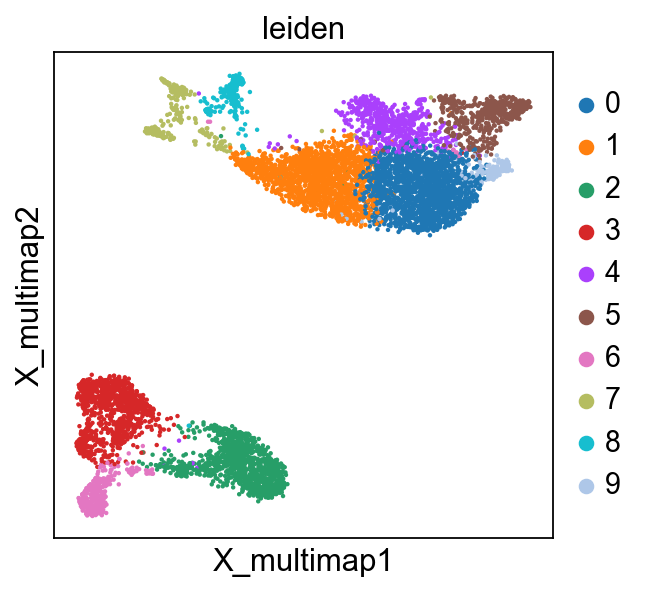

In [7]:
sc.tl.leiden(adata)
sc.pl.embedding(adata, 'X_multimap', color=['leiden'])

There are a number of parameters controllable from the MultiMAP function, for details check the [documentation](https://multimap.readthedocs.io/en/latest/). For example, using the `strengths` parameter to make the embedding rely more on ATAC data than RNA data alters the manifold in this fashion:

... storing 'cell_type' as categorical
... storing 'source' as categorical


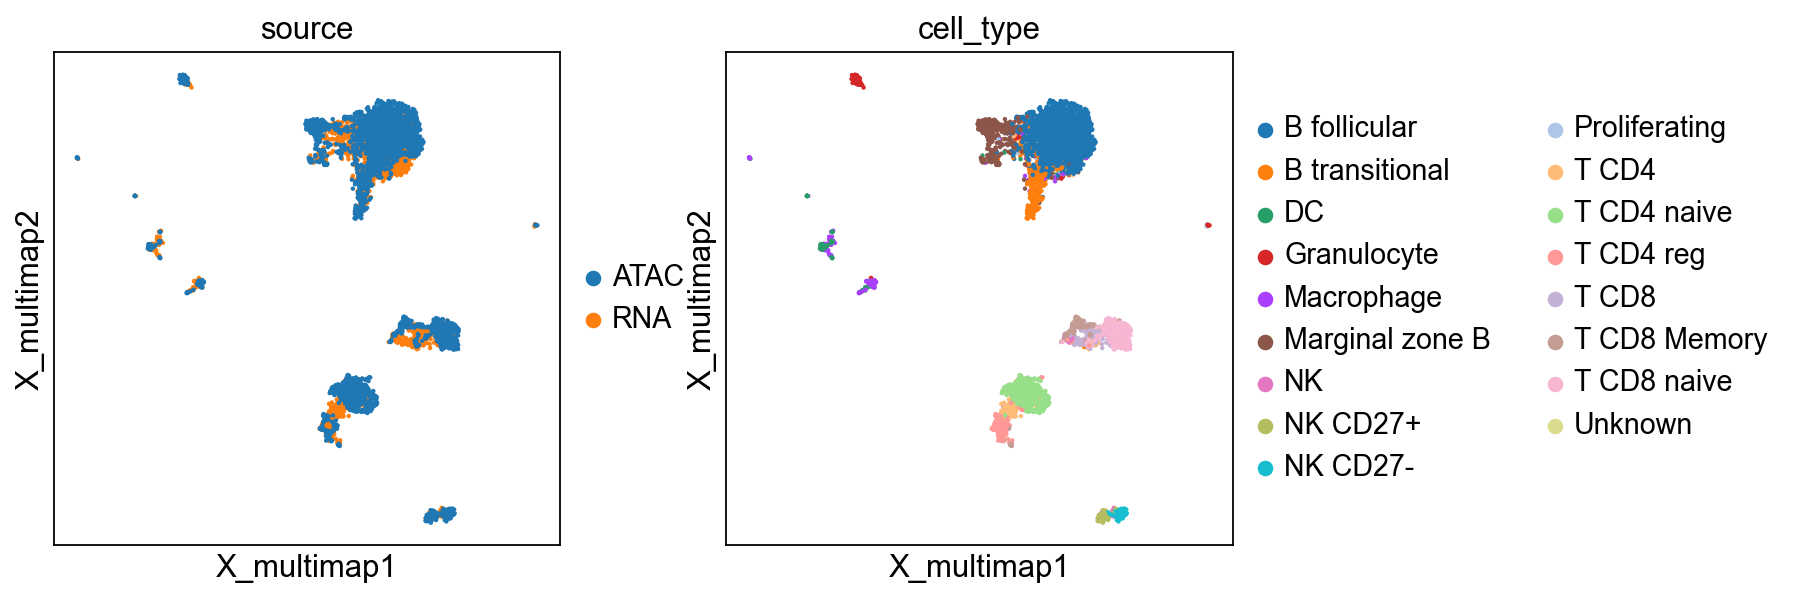

In [8]:
adata = MultiMAP.Integration([rna, atac_genes], ['X_pca', 'X_lsi'], strengths=[0,1])
sc.pl.embedding(adata, 'X_multimap', color=['source','cell_type'])

However, not all use cases require you to individually control the dataset's dimensionality reduction. Often you are fine with having the same dimensionality reduction ran on all of them, and just want to batch correct a single AnnData object. If this is the case, `MultiMAP.Batch()` is more fitting as it processes a single object and appends the graphs/manifold to it.

To demonstrate, let's load some pancreas data collected in four separate experiments. While the data is all RNA-Seq, there is a heavy batch effect present which MultiMAP can correct.

/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


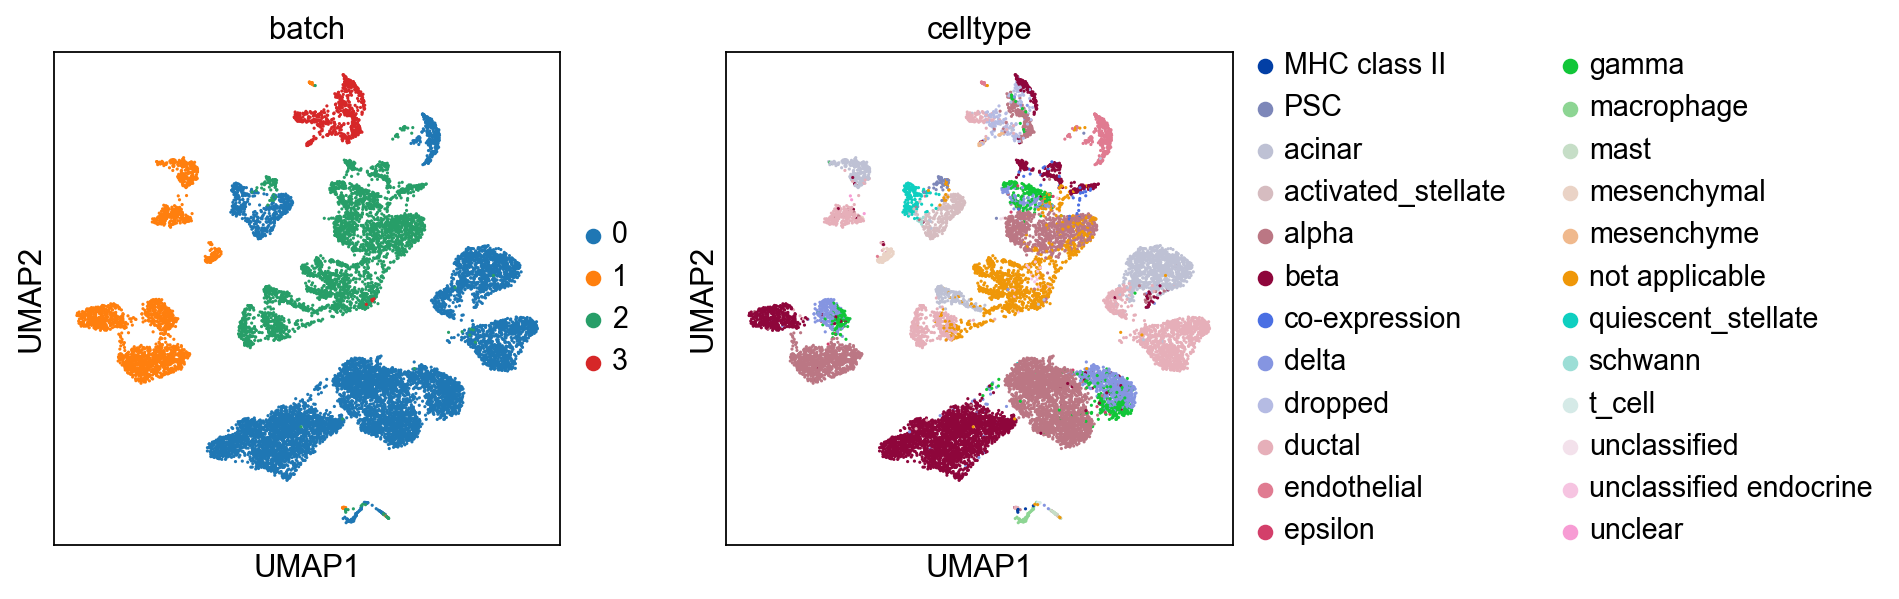

In [9]:
adata_source = sc.read('pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
sc.pl.umap(adata_source, color=['batch','celltype'])

As previously mentioned, MultiMAP prefers log-normalised input. This information is available in `.raw` of this object, so let's reconstruct an AnnData from it and re-filter it to the previously identified highly variable genes.

In [10]:
adata = anndata.AnnData(adata_source.raw.X, obs=adata_source.obs, var=adata_source.raw.var)
adata = adata[:,adata_source.var_names]

With this pre-processing complete, we can use this object as input for `MultiMAP.Batch()`. The result is a nicely integrated manifold.

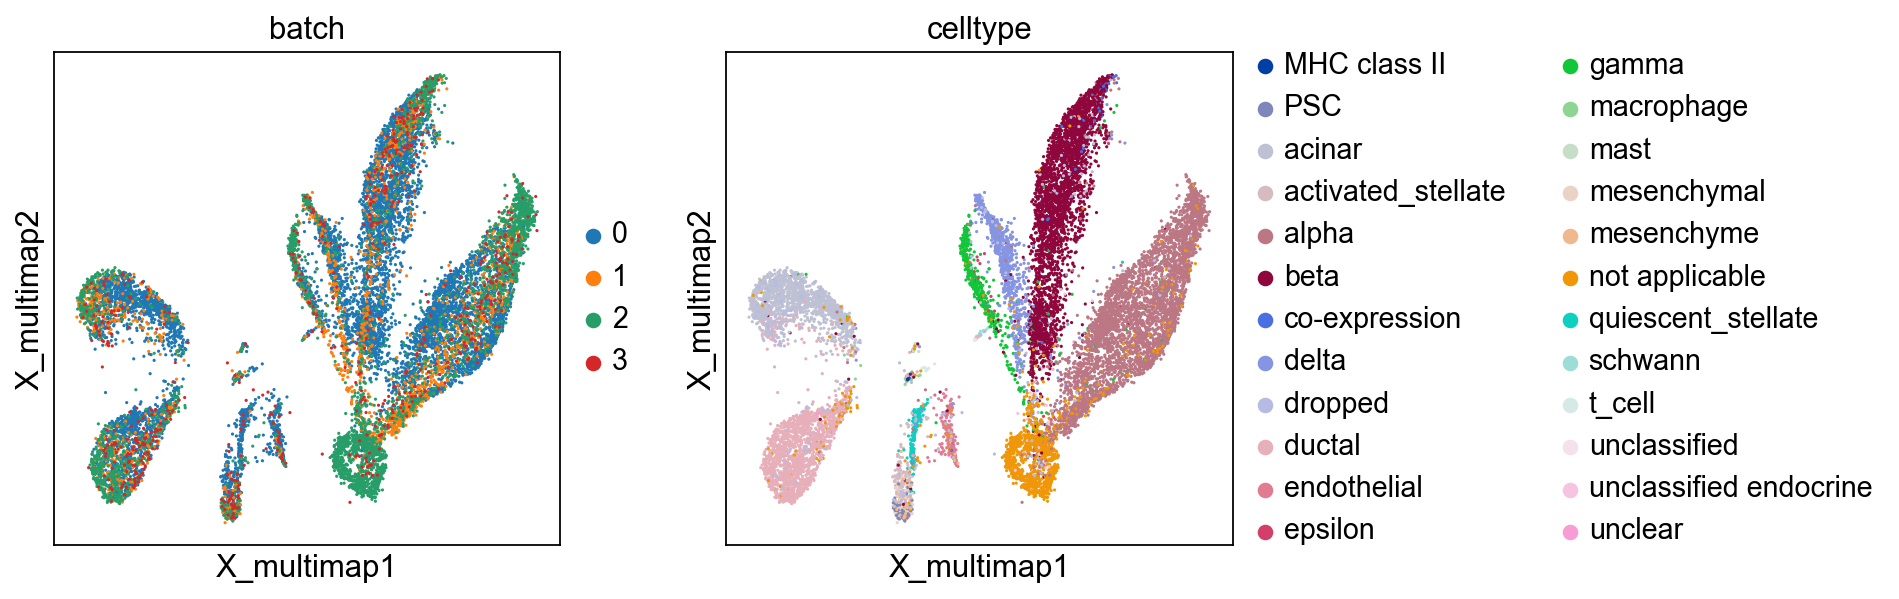

In [11]:
MultiMAP.Batch(adata)
sc.pl.embedding(adata, 'X_multimap', color=['batch','celltype'])

As previously, the MultiMAP output includes a graph which can be used for downstream application, such as clustering.

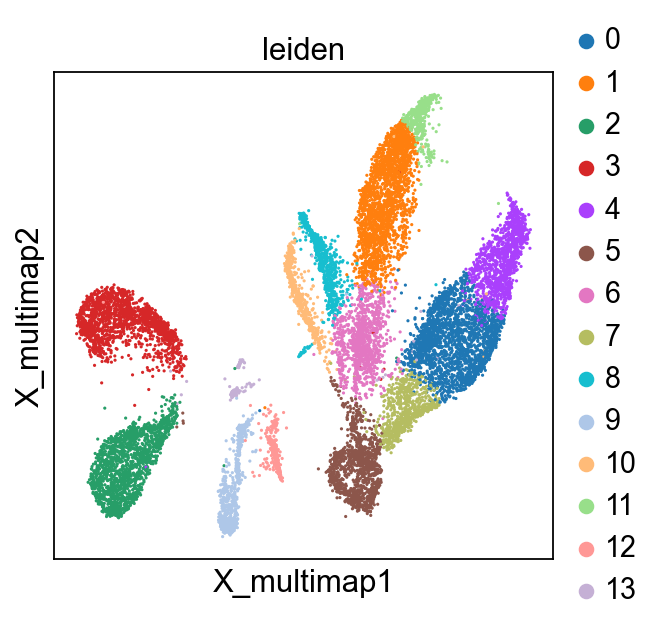

In [12]:
sc.tl.leiden(adata)
sc.pl.embedding(adata, 'X_multimap', color=['leiden'])

There's also an `embedding` parameter that allows you to skip generating the MultiMAP embedding. This will just have MultiMAP return the neighbourhood graph, which you can then use to make a UMAP. This can be more computationally tractable in some complex scenarios, but the MultiMAP embedding is generally preferable if possible. Works for both `Integration()` and `Batch()`. The graph is still as usable for downstream operations like clustering as ever.

         Falling back to preprocessing with `sc.pp.pca` and default params.


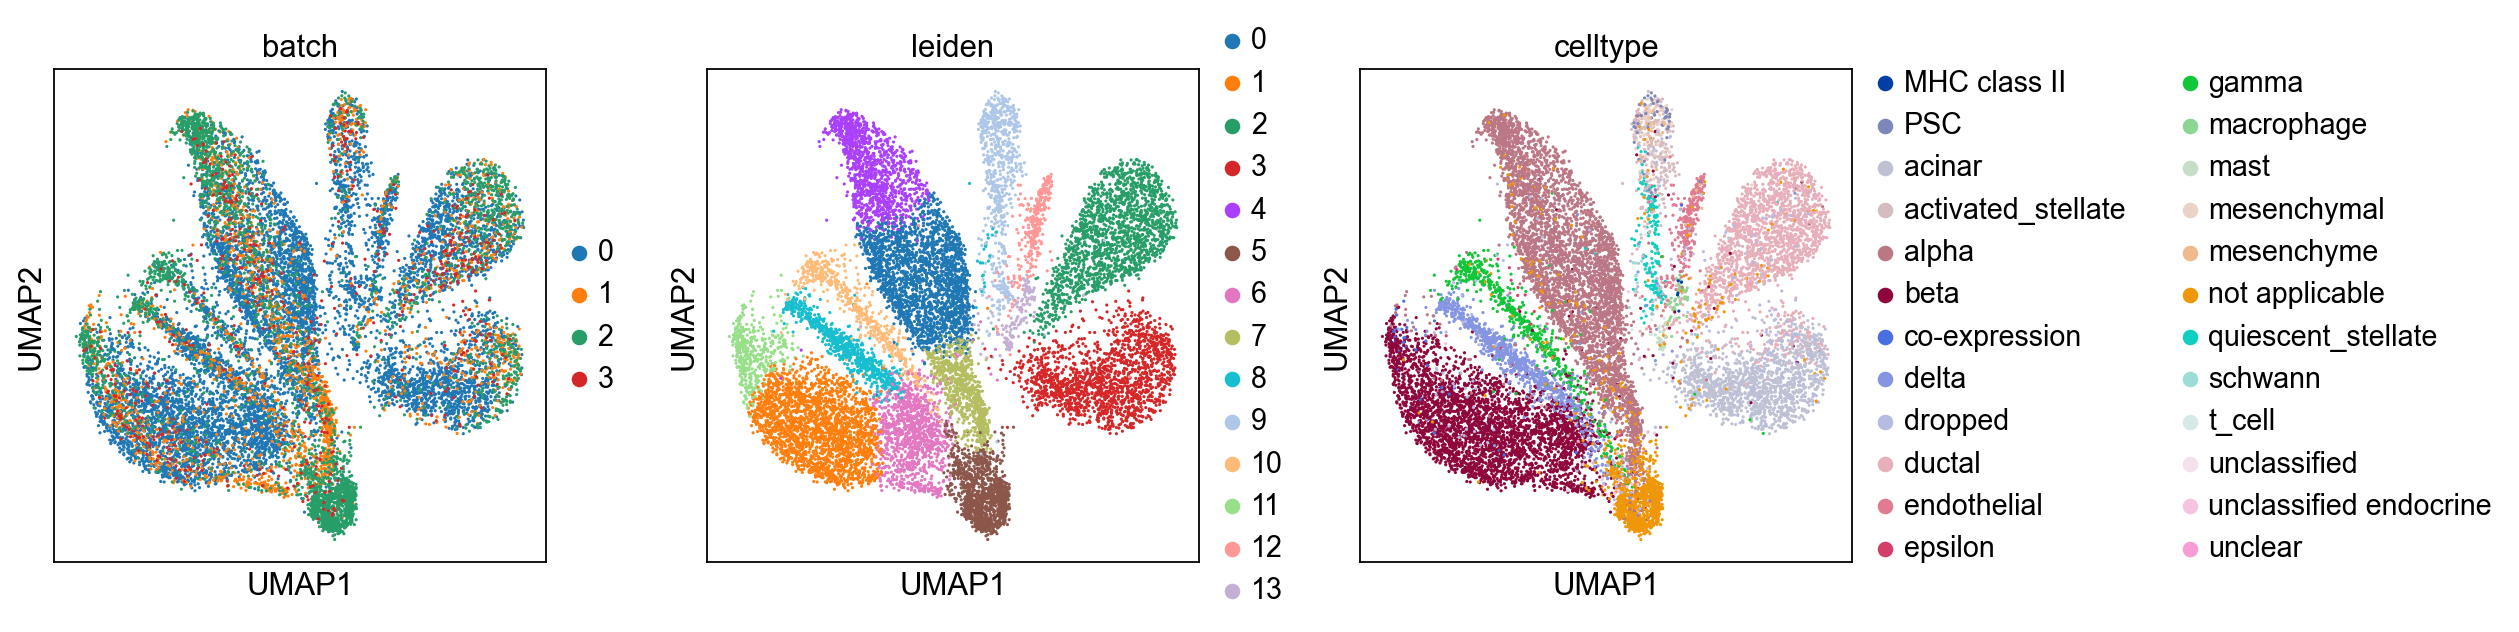

In [13]:
MultiMAP.Batch(adata, embedding=False)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['batch','leiden','celltype'])